In [35]:
import pandas as pd
import numpy as np
import re
import pickle
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
import nltk

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [41]:
# Load dataset
column_names = ["target", "id", "date", "flag", "user", "text"]
df = pd.read_csv("Twitter.csv", encoding='ISO-8859-1', names=column_names)



In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [45]:
# Convert target "4" to "1"
df.replace({'target': {4: 1}}, inplace=True)
# O Means Negative , 1 Means Positive



In [46]:
#Checking Unique users
df['user'].value_counts().head(10)

,count
user,
lost_dog,549
webwoke,345
tweetpet,310
SallytheShizzle,281
VioletsCRUK,279
mcraddictal,276
tsarnick,248
what_bugs_u,246
Karen230683,238


In [47]:
#Checking Duplicate Records
df.duplicated().sum()

0

In [48]:
df=df[['target','text']]

In [8]:
#check the occurances of the words quot ,lol , amp
print(df['text'].str.contains('quot').sum())
print(df['text'].str.contains('lol').sum())
print(df['text'].str.contains('amp').sum())

35252
40308
54088


In [9]:
#remove these words from the text column
df['text'] = df['text'].str.replace('quot', '')
df['text'] = df['text'].str.replace('amp', '')



In [10]:
#check the occurances of the words quot ,lol , amp
print(df['text'].str.contains('quot').sum())
print(df['text'].str.contains('amp').sum())

0
0


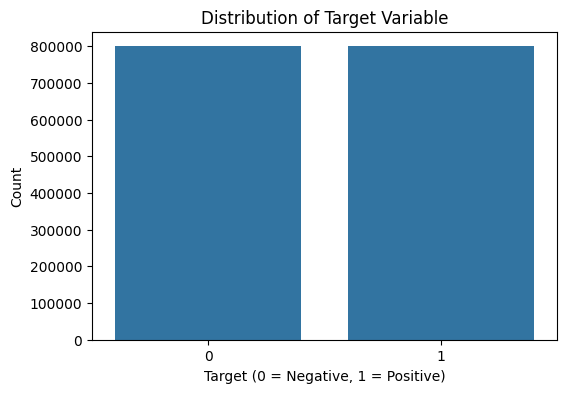

In [11]:
# Exploratory Data Analysis (EDA)
# 1. Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title("Distribution of Target Variable")
plt.xlabel("Target (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()



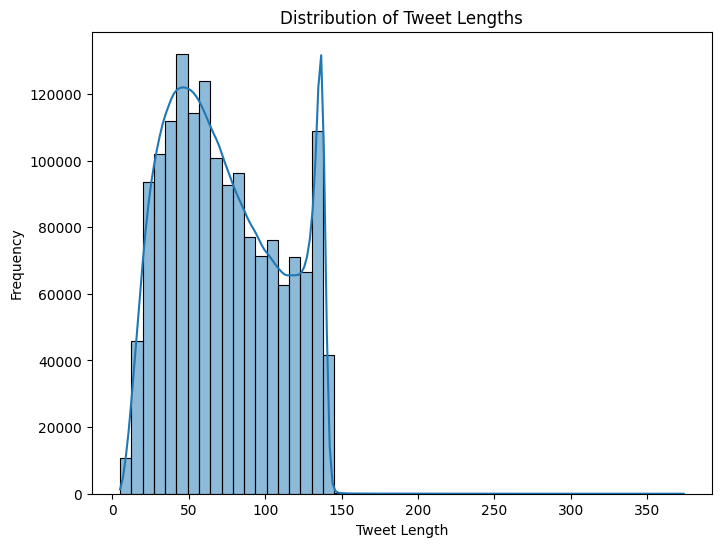

In [12]:
# 2. Distribution of tweet lengths
df['tweet_length'] = df['text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['tweet_length'], bins=50, kde=True)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()



In [13]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [14]:
# Text Cleaning & Preprocessing
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
userPattern       = '@[^\s]+'
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # Remove special characters
    text = re.sub(r'((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)', '', text)  # Remove URLs
    for emoji in emojis.keys():
      text = text.replace(emoji, "EMOJI" + emojis[emoji])
    # Replace @USERNAME to 'USER'.
    text = re.sub(userPattern,' USER', text)
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(sequencePattern, seqReplacePattern, text) # Replace 3 or more consecutive letters by 2 letter.
    translator = str.maketrans('', '', punctuations_list)
    text = text.lower()
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)




In [15]:
import time
t = time.time()
# Apply the preprocessing to the txt column
df['clean_text'] = df['text'].apply(preprocess_text)
print(f'Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Preprocessing complete.
Time Taken: 2475 seconds


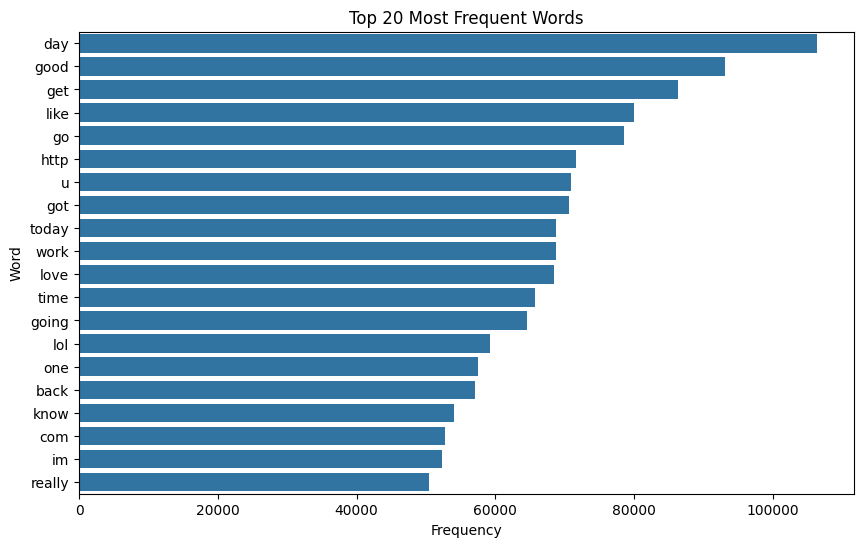

In [16]:
# 3. Most frequent words
from collections import Counter

all_words = ' '.join(df['clean_text']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[1] for word in most_common_words], y=[word[0] for word in most_common_words])
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()



In [17]:
# WordCloud for positive and negative tweets
positive_text = ' '.join(df[df['target'] == 1]['clean_text'])
negative_text = ' '.join(df[df['target'] == 0]['clean_text'])


(-0.5, 1599.5, 799.5, -0.5)

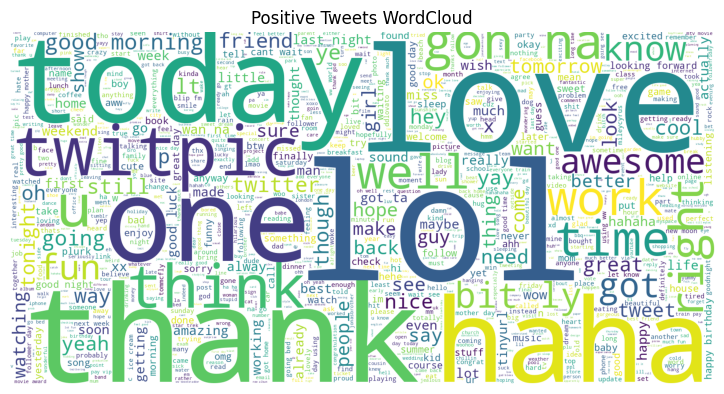

In [18]:

# Positive Tweets WordCloud
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(max_words=1000,width=1600, height=800, background_color='white').generate(positive_text))
plt.title("Positive Tweets WordCloud")
plt.axis("off")



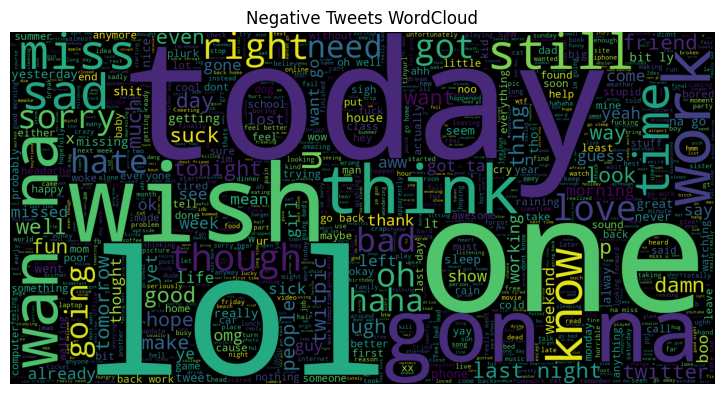

In [19]:
# Negative Tweets WordCloud
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.imshow(WordCloud(max_words=1000,width=1600, height=800, background_color='black').generate(negative_text))
plt.title("Negative Tweets WordCloud")
plt.axis("off")
plt.show()



In [29]:
# Split data into training and testing sets
X = df['clean_text'].values
Y = df['target'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)



In [21]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)



In [22]:
# Save TF-IDF Vectorizer
import pickle
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [23]:
# Train THe ML Model
model = LogisticRegression(max_iter=1000, C=1, penalty='l2', solver='liblinear')
model.fit(X_train_transformed, Y_train)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [24]:
# Save Logistic Regression Model
with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [25]:
# Accuracy score on the training data
X_train_prediction=model.predict(X_train_transformed)
train_data_accuracy=accuracy_score(Y_train,X_train_prediction)
print(train_data_accuracy)

0.8166125


In [26]:
#Accuracy Score on the test data
X_test_prediction=model.predict(X_test_transformed)
test_data_accuracy=accuracy_score(Y_test,X_test_prediction)
print(test_data_accuracy)

0.783559375


In [28]:
from sklearn.metrics import classification_report,confusion_matrix

print("Logistic Regression Report:")
print(classification_report(Y_test, X_test_prediction))



Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78    160000
           1       0.77      0.80      0.79    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



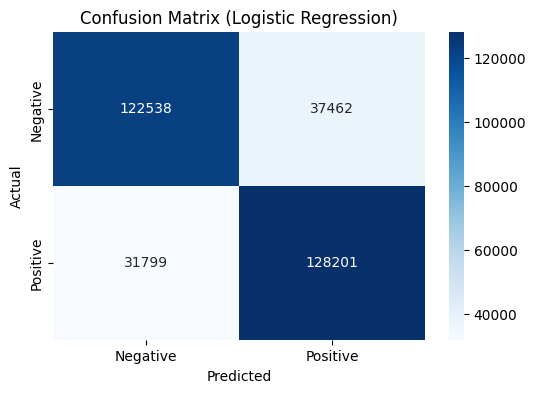

In [ ]:
# Confusion Matrix for Logistic Regression
cm = confusion_matrix(Y_test, X_test_prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Load Logistic Regression Model for Testing
def load_logistic_model():
    with open("logistic_regression_model.pkl", "rb") as f:
        model = pickle.load(f)
    return model

In [ ]:
def predict_sentiment(text):
    model = load_logistic_model()
    with open("tfidf_vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    text_tfidf = vectorizer.transform([preprocess_text(text)])
    prediction = model.predict(text_tfidf)
    return "Positive" if prediction[0] == 1 else "Negative"

# Example Test
print(predict_sentiment("I love this product!"))
print(predict_sentiment("This is the worst experience ever."))


Positive
Negative


Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization strength
#     'penalty': ['l1', 'l2'],  # Regularization type
#     'solver': ['lbfgs', 'liblinear', 'newton-cg']   # Solver for optimization
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# # Fit the model
# grid_search.fit(X_train_transformed, Y_train)

# # Best parameters and score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# # Evaluate on test data
# best_model = grid_search.best_estimator_
# X_test_prediction = best_model.predict(X_test_transformed)
# test_accuracy = accuracy_score(Y_test, X_test_prediction)
# print("Test Accuracy with Best Model:", test_accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.78124375
Test Accuracy with Best Model: 0.783165625


RandomForest Model


Tuned Random Forest Training Accuracy: 0.7482
Tuned Random Forest Test Accuracy: 0.7434
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74    160000
           1       0.74      0.75      0.74    160000

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



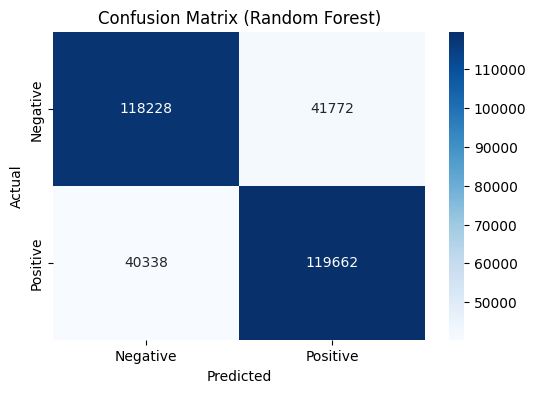

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Adjusted hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=200,       # More trees for better performance
    max_depth=30,           # Deep trees to capture patterns
    min_samples_split=5,    # Prevents overfitting by requiring more samples to split
    min_samples_leaf=2,     # Ensures leaves aren't too small
    random_state=2,         # Ensures reproducibility
    n_jobs=-1               # Uses all processors for efficiency
)

# Train the model
rf_model.fit(X_train_transformed, Y_train)

# Predictions
X_train_rf_pred = rf_model.predict(X_train_transformed)
X_test_rf_pred = rf_model.predict(X_test_transformed)

# Accuracy
train_rf_accuracy = accuracy_score(Y_train, X_train_rf_pred)
test_rf_accuracy = accuracy_score(Y_test, X_test_rf_pred)

print(f"Tuned Random Forest Training Accuracy: {train_rf_accuracy:.4f}")
print(f"Tuned Random Forest Test Accuracy: {test_rf_accuracy:.4f}")

# Classification Report
print("Tuned Random Forest Classification Report:")
print(classification_report(Y_test, X_test_rf_pred))

# Confusion Matrix
cm_rf = confusion_matrix(Y_test, X_test_rf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# LSTM Model
max_words = 5000
max_length = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)
# Save Tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)



In [ ]:
# Save and load model weights to avoid retraining
model_path = "/content/lstm_model.h5"

try:
    # Load pre-trained model if it exists
    model = load_model(model_path)
    print("Loaded pre-trained LSTM model.")
except:
    # Train new model if no pre-trained model exists
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train_seq, Y_train, epochs=5, batch_size=64, validation_data=(X_test_seq, Y_test), verbose=1)
    model.save(model_path)
    print("Saved trained LSTM model.")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 2607s 130ms/step - accuracy: 0.7587 - loss: 0.4911 - val_accuracy: 0.7804 - val_loss: 0.4603
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 2590s 129ms/step - accuracy: 0.7827 - loss: 0.4543 - val_accuracy: 0.7838 - val_loss: 0.4534
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 2604s 130ms/step - accuracy: 0.7885 - loss: 0.4448 - val_accuracy: 0.7853 - val_loss: 0.4519
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 2606s 130ms/step - accuracy: 0.7938 - loss: 0.4371 - val_accuracy: 0.7865 - val_loss: 0.4504
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 2596s 130ms/step - accuracy: 0.7965 - loss: 0.4320 - val_accuracy: 0.7868 - val_loss: 0.4513


Saved trained LSTM model.


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 209s 21ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78    160000
           1       0.78      0.80      0.79    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



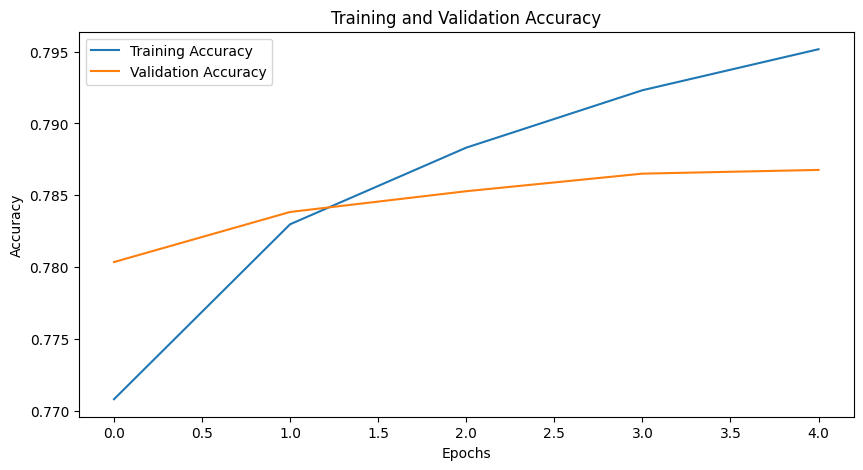

In [ ]:
# Evaluate LSTM Model
y_pred = (model.predict(X_test_seq) > 0.5).astype(int)
print("LSTM Classification Report:")
print(classification_report(Y_test, y_pred))

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()